# End-To-End: Countries Multi-file Modeling

In [1]:
import os

from neo4j_runway import Discovery
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files

from dotenv import load_dotenv

load_dotenv()

True

# Load Data

In [2]:
data_directory = "../../../data/countries/"

use_cases = [
    "How many subregions are in a region and how many countries are in a subregion?",
    "What is the most common currency?",
    "Which subregions contain the most cities?"
    ]

data_dictionary = load_data_dictionary_from_yaml("./data_dictionary.yaml")

data = load_local_files(data_directory=data_directory, 
                        general_description="These files contain information on countries.", 
                        use_cases=use_cases, 
                        data_dictionary=data_dictionary)

## Visualize Some Data

### Countries

In [3]:
data.table_dict.get("countries.csv").dataframe.head()

,id,name,capital,currency,region,subregion
0,1,Afghanistan,Kabul,AFN,Asia,Southern Asia
1,2,Aland Islands,Mariehamn,EUR,Europe,Northern Europe
2,3,Albania,Tirana,ALL,Europe,Southern Europe
3,4,Algeria,Algiers,DZD,Africa,Northern Africa
4,5,American Samoa,Pago Pago,USD,Oceania,Polynesia


### States

In [4]:
data.table_dict.get("states.csv").dataframe.head()

,id,name,country_id
0,3901,Badakhshan,1
1,3871,Badghis,1
2,3875,Baghlan,1
3,3884,Balkh,1
4,3872,Bamyan,1


### Cities

In [5]:
data.table_dict.get("cities.csv").dataframe.head()

,id,name,state_id,country_id
0,52,Ashkāsham,3901,1
1,68,Fayzabad,3901,1
2,78,Jurm,3901,1
3,84,Khandūd,3901,1
4,115,Rāghistān,3901,1


# Discovery

In [6]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini-2024-07-18", enable_async=True)
discovery = Discovery(llm=disc_llm, data=data)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/discovery/discovery.py:137: ExperimentalFeatureWarning: Multi file Discovery is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [7]:
discovery.run_async(num_calls=3)

### Summary of Insights for Graph Data Model

#### Unique Identifiers
- **State ID (`id`)**: Unique identifier for each state in the `states.csv` dataset.
- **City ID (`id`)**: Unique identifier for each city in the `cities.csv` dataset.
- **Country ID (`id`)**: Unique identifier for each country in the `countries.csv` dataset.

#### Significant Properties
- **State Name (`name`)**: Name of the state.
- **City Name (`name`)**: Name of the city.
- **Country Name (`name`)**: Name of the country.
- **Capital (`capital`)**: Name of the capital city for each country.
- **Currency (`currency`)**: Currency used by each country.
- **Region (`region`)**: Region to which the country belongs.
- **Subregion (`subregion`)**: Subregion to which the country belongs.

#### Possible Node Labels
1. **State**: Represents each state with properties like `id` and `name`.
2. **City**: Represents each city with properties like `id` and `name`.
3. **Country**: Represents each country with properties like `id`, `name`, `capital`, `currency`, `region`, and `subregion`.
4. **Subregion**: Represents each subregion, which can be derived from the countries.

#### Possible Relationships
- **(State)-[:BELONGS_TO]->(Country)**: Indicates that a state belongs to a specific country.
- **(City)-[:LOCATED_IN]->(State)**: Indicates that a city is located within a specific state.
- **(Country)-[:PART_OF]->(Subregion)**: Indicates that a country is part of a specific subregion.
- **(Country)-[:HAS_CURRENCY]->(Currency)**: Indicates the currency used by a country.

#### Insights Addressing Use Cases
1. **Subregions and Countries**: The `Country` node can be linked to the `Subregion` node, allowing for queries to count how many countries exist within each subregion and how many subregions exist within a region.
2. **Most Common Currency**: The `Currency` property in the `Country` node can be aggregated to determine the most common currency across countries.
3. **Subregions with Most Cities**: By linking `City` nodes to `State` nodes and then to `Country` nodes, we can aggregate city counts based on their respective subregions to identify which subregions contain the most cities.

## Save Insights

In [8]:
# discovery.to_markdown(file_dir="./outputs/")

# Data Modeling

In [9]:
from neo4j_runway import GraphDataModeler

In [10]:
modeling_llm = OpenAIDataModelingLLM(model_name="gpt-4o", model_params={"temperature": 0.3})
gdm = GraphDataModeler(llm=modeling_llm, discovery=discovery)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/modeler/modeler.py:115: ExperimentalFeatureWarning: Multi file Data Modeling is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [11]:
gdm.create_initial_model()

> Generating Nodes...
Attempts | 2  
Received Valid Nodes
Nodes
* (:State)     * (:City)
* (:Country)   * (:Subregion) 

> Generating Data Model...
Attempts | 1  
Received Valid Data Model
Nodes
* (:State)     * (:City)
* (:Country)   * (:Subregion) 

Relationships
* (:State)-[:BELONGS_TO]->(:Country)    
* (:City)-[:LOCATED_IN]->(:State)       
* (:Country)-[:PART_OF]->(:Subregion)   


DataModel(nodes=[Node(label='State', properties=[Property(name='stateId', type='str', column_mapping='id', alias='state_id', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='states.csv'), Node(label='City', properties=[Property(name='cityId', type='str', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='cities.csv'), Node(label='Country', properties=[Property(name='countryId', type='str', column_mapping='id', alias='country_id', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='currency', type='str', column_mapping='currency', al

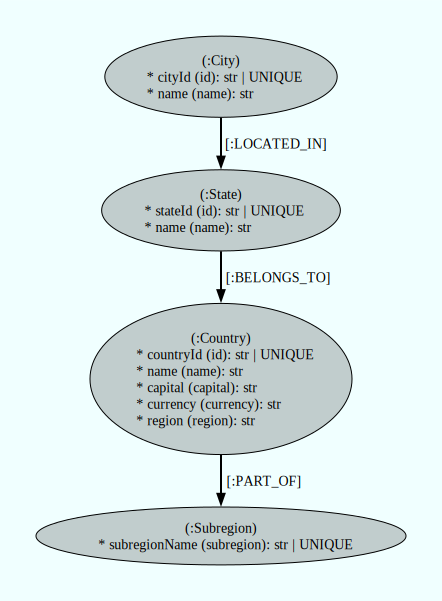

In [12]:
gdm.current_model.visualize()

In [13]:
corrections = "Create currency and region nodes"

gdm.iterate_model(corrections=corrections)

> Generating Data Model...
Attempts | 2  
Received Valid Data Model
Nodes
* (:State)      * (:City)
* (:Country)    * (:Subregion)
* (:Currency)   * (:Region) 

Relationships
* (:State)-[:BELONGS_TO]->(:Country)    
* (:City)-[:LOCATED_IN]->(:State)       
* (:Country)-[:PART_OF]->(:Subregion)   
* (:Country)-[:USES]->(:Currency)       
* (:Subregion)-[:PART_OF]->(:Region)    


DataModel(nodes=[Node(label='State', properties=[Property(name='stateId', type='str', column_mapping='id', alias='state_id', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='states.csv'), Node(label='City', properties=[Property(name='cityId', type='str', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='cities.csv'), Node(label='Country', properties=[Property(name='countryId', type='str', column_mapping='id', alias='country_id', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False)], source_name='countries.csv'), Node(label='Subregion', properties=[

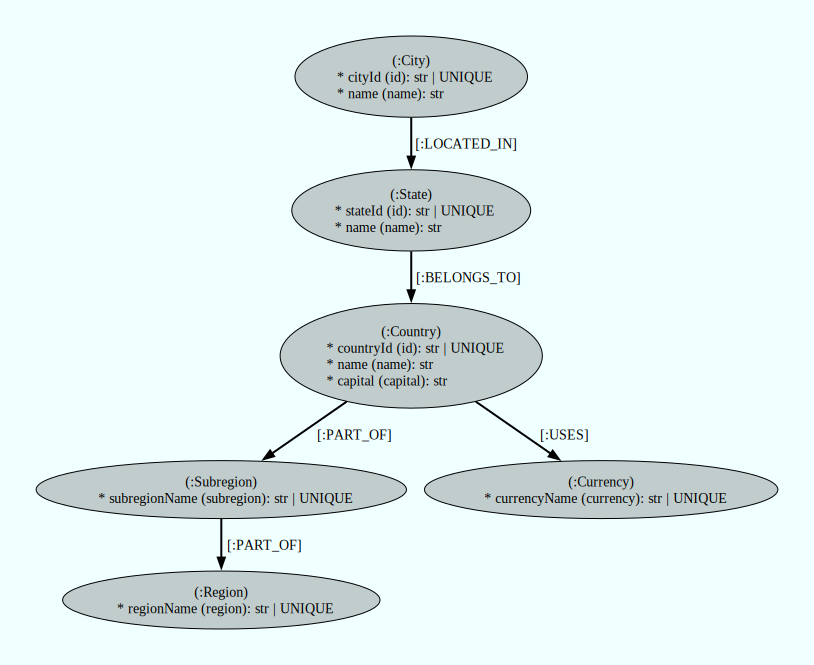

In [14]:
gdm.current_model.visualize()

## Ingestion Code Generation

In [ ]:
from neo4j_runway.code_generation import PyIngestConfigGenerator 

In [19]:
code_generator = PyIngestConfigGenerator(data_model=gdm.current_model, 
                                         username="neo4j", 
                                         password="password", 
                                         uri=os.environ.get("NEO4J_URI"), 
                                         database="neo4j",
                                         file_directory=data_directory)

In [20]:
config = code_generator.generate_config_string()

In [21]:
print(config)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT state_stateid IF NOT EXISTS FOR (n:State) REQUIRE n.stateId IS UNIQUE;
  - CREATE CONSTRAINT city_cityid IF NOT EXISTS FOR (n:City) REQUIRE n.cityId IS UNIQUE;
  - CREATE CONSTRAINT country_countryid IF NOT EXISTS FOR (n:Country) REQUIRE n.countryId IS UNIQUE;
  - CREATE CONSTRAINT subregion_subregionname IF NOT EXISTS FOR (n:Subregion) REQUIRE n.subregionName IS UNIQUE;
  - CREATE CONSTRAINT currency_currencyname IF NOT EXISTS FOR (n:Currency) REQUIRE n.currencyName IS UNIQUE;
  - CREATE CONSTRAINT region_regionname IF NOT EXISTS FOR (n:Region) REQUIRE n.regionName IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:State {stateId: row.id})
    SET n.name = row.name
  url: $BASE/../../../data/countries/states.csv
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
  

## Ingest

In [22]:
from neo4j_runway import PyIngest

In [23]:
PyIngest(config=config)